In [2]:
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict, Counter

import time
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

import re
import os
import scipy
import scipy.stats as stats
from statsmodels.stats.multitest import *

import sys
sys.path.append("/home/yara/Documents/PseudoFind")
from PseudoFind.pangenome_cmds import *
from PseudoFind.functional_annotations import *

import matplotlib
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [3]:
from scipy.signal import savgol_filter

In [4]:
sys.path.append("/home/yara/Documents/pangenome_curves")
from pangenome_curves.get_curves import *

In [5]:
# generate pan-genome and pan allelome curves (maybe even pan-nucleotide allelome?)

# core genome sensitivity analysis

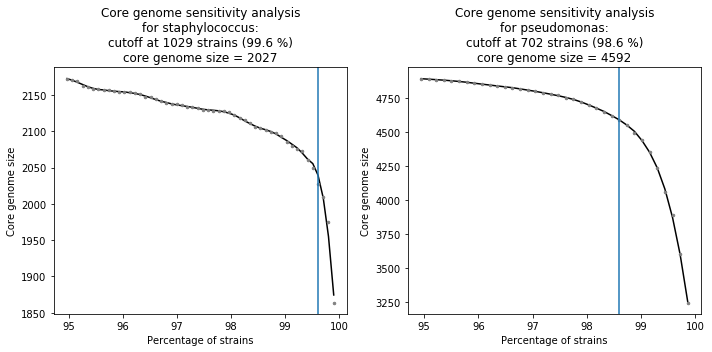

In [7]:
# from scipy.signal import savgol_filter

fig, axes = plt.subplots(1,2, figsize = (10, 5))
i = 0

cutoffs = {}


for spe in ['staphylococcus', 'pseudomonas']:
    
    cdhit_clusters = get_cdhit_clusters('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/%s_pangenome_cdhit.clstr'%(spe, spe))
    cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}
    cdhit_in_genomes = defaultdict(dict)
    for gene_id, cluster_id in cdhit_clusters_rev.items():
        if gene_id != '':
            cdhit_in_genomes[gene_id.split('_')[0]].update({cluster_id: 1})
    cdhit_in_genomes = pd.DataFrame(cdhit_in_genomes).fillna(0)

    no_genomes_range = [i for i in range(int(95*cdhit_in_genomes.shape[1]/100), cdhit_in_genomes.shape[1])]
    cutoff2core = {100*i/cdhit_in_genomes.shape[1]:sum(cdhit_in_genomes.sum(axis = 1) >= i) for i in no_genomes_range}
    cutoff2core = OrderedDict(sorted(cutoff2core.items(), key = lambda a:a[0]))
    
    Xrange, Ydata = np.array(list(cutoff2core.keys())), np.array(list(cutoff2core.values()))
    Ypred = scipy.signal.savgol_filter(Ydata , 9, 3)
    axes[i].plot(Xrange, Ypred, '-', color = 'k')
    axes[i].plot(Xrange, Ydata, '.', color = 'grey', markersize = 5)
    axes[i].set_xlabel('Percentage of strains')
    axes[i].set_ylabel('Core genome size')

    cutoff = list(cutoff2core.keys())[sum(abs(np.diff(np.array(list(cutoff2core.values())))) < 0.01*min(cutoff2core.values()))]
    axes[i].axvline(cutoff)
    no_strains = int(cutoff*cdhit_in_genomes.shape[1]/100)
    text = 'Core genome sensitivity analysis\nfor %s:\ncutoff at %s strains (%s %%)\ncore genome size = %s'%(spe, no_strains, str(round(cutoff,1)), str(cutoff2core[cutoff]))
    axes[i].set_title(text)
    
    cutoffs[spe] = cutoff
    
    i += 1
    
plt.tight_layout()
plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/Figure_S1_coregenome_sensitivity.svg')
plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/Figure_S1_coregenome_sensitivity.png')

In [9]:
cdhit_clusters = get_cdhit_clusters('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/staphylococcus_pangenome_cdhit.clstr')
cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}
cdhit_in_genomes = defaultdict(dict)
for gene_id, cluster_id in cdhit_clusters_rev.items():
    if gene_id != '':
        cdhit_in_genomes[gene_id.split('_')[0]].update({cluster_id: 1})
cdhit_in_genomes = pd.DataFrame(cdhit_in_genomes).fillna(0)
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str})
d = {'full': SoI_FT['Genome ID'].tolist(), 'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['Genome ID'].tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['Genome ID'].tolist()}


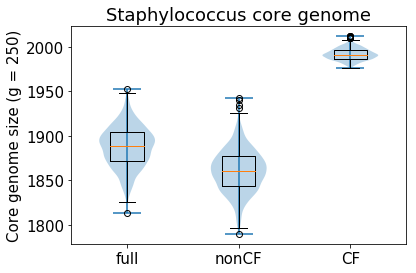

In [64]:
# core_sizes = defaultdict(list)
# keywords = ['CF', 'nonCF', 'full']

# for keyword, gids in d.items():
#     for i in range(1000):
#         gid_list = list(set(gids) & set(cdhit_in_genomes.columns))
#         np.random.shuffle(gid_list)   
#         pan_i = cdhit_in_genomes[gid_list[:250]]
#         cutoff_i = cutoffs['staphylococcus']*250/100
#         core_sizes['staphylococcus %s'%keyword].append(sum(pan_i.sum(axis = 1) > cutoff_i))

        
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, ax = plt.subplots(1,1)
keywords = ['full', 'nonCF', 'CF']
ax.boxplot(list([core_sizes['staphylococcus %s'%x] for x in keywords]), positions = [1,2,3])
ax.violinplot(list([core_sizes['staphylococcus %s'%x] for x in keywords]), positions = [1,2,3])
ax.set_xticks([1,2,3])
ax.set_xticklabels(keywords)
ax.set_ylabel('Core genome size (g = 250)')
ax.set_title('Staphylococcus core genome')
fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/core_genome_size_staphylococcus.svg')

In [1]:
# P. aeruginosa

cdhit_clusters = get_cdhit_clusters('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pseudomonas_pangenome_cdhit.clstr')
cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}
cdhit_in_genomes = defaultdict(dict)
for gene_id, cluster_id in cdhit_clusters_rev.items():
    if gene_id != '':
        cdhit_in_genomes[gene_id.split('_')[0]].update({cluster_id: 1})
cdhit_in_genomes = pd.DataFrame(cdhit_in_genomes).fillna(0)

NameError: name 'get_cdhit_clusters' is not defined

In [94]:
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f3.csv', dtype = {'Genome ID':str})
d = {'full': SoI_FT['Genome ID'].tolist(), 'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['Genome ID'].tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['Genome ID'].tolist()}

# core_sizes = defaultdict(list)
keywords = ['CF', 'nonCF', 'full']
cutoff_i = cutoffs['pseudomonas']*250/100

for keyword, gids in d.items():
    gid_list = list(set(gids) & set(cdhit_in_genomes.columns))
    core_sizes['pseudomonas %s'%keyword] = []
    for i in range(1000):
        np.random.shuffle(gid_list)   
        pan_i = cdhit_in_genomes[gid_list[:250]]
        core_sizes['pseudomonas %s'%keyword].append(sum(pan_i.sum(axis = 1) > cutoff_i))
        core_genomes['pseudomonas %s'%keyword] += pan_i.loc[pan_i.sum(axis = 1) > cutoff_i].index.tolist()
        
pickle.dump(core_sizes, open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/core_sizes.p', 'wb'))

In [216]:
sum(pan_i.sum(axis = 1) > cutoff_i)

4538

In [172]:
core_genomes = defaultdict(list)
bootstrap_no = 500

for keyword, gids in d.items():
    gid_list = list(set(gids) & set(cdhit_in_genomes.columns))
    core_sizes['pseudomonas %s'%keyword] = []
    for i in range(bootstrap_no):
        np.random.shuffle(gid_list)   
        pan_i = cdhit_in_genomes[gid_list[:250]]  
        core_genomes['pseudomonas %s'%keyword] += pan_i.loc[pan_i.sum(axis = 1) > cutoff_i].index.tolist()   

In [215]:
sum(core_genomes_f['pseudomonas nonCF']), sum(core_genomes_f['pseudomonas CF'])

(4429.0, 4324.0)

In [212]:
core_genomes_f = {key: {x:1 for x,y in Counter(value).items() if y == bootstrap_no} for key, value in core_genomes.items()}
core_genomes_f = pd.DataFrame(core_genomes_f).fillna(0)
core_CFspecific = core_genomes_f.loc[core_genomes_f['pseudomonas CF'] == 1].loc[core_genomes_f.sum(axis = 1) == 1].index
core_nonCFspecific = core_genomes_f.loc[core_genomes_f['pseudomonas nonCF'] == 1].loc[core_genomes_f.sum(axis = 1) == 1].index

len(core_CFspecific), len(core_nonCFspecific)

(231, 336)

In [201]:
from matplotlib_venn import venn3

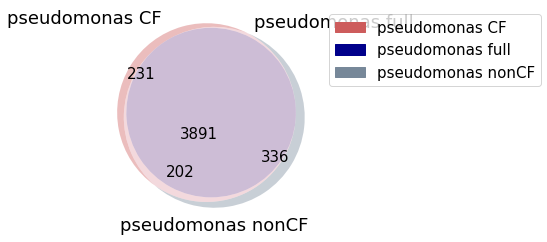

In [209]:
venn3([set(core_genomes_f.loc[core_genomes_f[key] == 1].index) for key in core_genomes_f.columns], core_genomes_f.columns, set_colors = ['indianred', 'darkblue', 'lightslategrey'])
plt.legend(handles = [mpatches.Patch(color = c, label = l) for l, c in zip(core_genomes_f.columns, ['indianred', 'darkblue', 'lightslategrey'])],
          bbox_to_anchor = (1,1))

In [174]:
cdhit_metadatar = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/cdhit_metadatar.p', 'rb'))
# OrderedDict(sorted(Counter([cdhit_metadatar[x]['product'] for x in core_CFspecific]).items(), key = lambda a: a[1], reverse = True))

In [178]:
core_sizes = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/core_sizes.p', 'rb'))

In [182]:
np.median(core_sizes['pseudomonas CF']) -  np.median(core_sizes['pseudomonas nonCF']) 

147.0

In [211]:
100*(np.mean(core_sizes['staphylococcus CF']) / np.mean(core_sizes['staphylococcus nonCF']) -1)

7.0470018681221935

In [137]:
100*(np.mean(core_sizes['pseudomonas CF']) / np.mean(core_sizes['pseudomonas nonCF']) -1)

3.1137749368575385

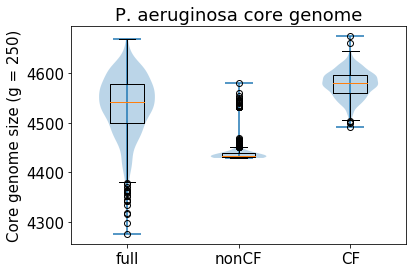

In [96]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, ax = plt.subplots(1,1)
keywords = ['full', 'nonCF', 'CF']
ax.boxplot(list([core_sizes['pseudomonas %s'%x] for x in keywords]), positions = [1,2,3])
ax.violinplot(list([core_sizes['pseudomonas %s'%x] for x in keywords]), positions = [1,2,3])
ax.set_xticks([1,2,3])
ax.set_xticklabels(keywords)
ax.set_ylabel('Core genome size (g = 250)')
ax.set_title('P. aeruginosa core genome')

fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/core_genome_size_pseudommonas.svg')

# pan genome curves

In [216]:
# no = input_matrix.shape[1]
# core, pan = {}, {}

# start = time.time()
# for i, gid in enumerate(gid_list):
#     pan_i = input_matrix[:,gid_list[:i+1]]
#     pan[i] = np.array(sum(pan_i.sum(axis = 1) > 0))[0][0]
#     core[i] = np.array(sum(pan_i.sum(axis = 1) > cutoff*i))[0][0]
    
# end = time.time()

In [159]:
# # S. aureus
cdhit_clusters = get_cdhit_clusters('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/staphylococcus_pangenome_cdhit.clstr')
cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}
cdhit_in_genomes = defaultdict(dict)
for gene_id, cluster_id in cdhit_clusters_rev.items():
    if gene_id != '':
        cdhit_in_genomes[gene_id.split('_')[0]].update({cluster_id: 1})
cdhit_in_genomes = pd.DataFrame(cdhit_in_genomes).fillna(0)


bootstrap_no = 1000
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str})
d = {'full': SoI_FT['Genome ID'].tolist(), 'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['Genome ID'].tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['Genome ID'].tolist()}

for keyword, subset in d.items():
    input_data = cdhit_in_genomes[list(set(cdhit_in_genomes.columns) & set(subset))]
    output_file = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/pangenome_sample_%s.csv'%keyword
    pangenome_res = get_pangenome_counts(input_data, bootstrap_no, output_file = output_file)
    pangenome_res.to_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/pangenome_res_%s.csv'%keyword)

/home/yara/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29 DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [50]:
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f.csv', dtype = {'Genome ID':str})
pseudomonas_seq_lengths = SoI_FT['Genome Length']

In [54]:
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f.csv', dtype = {'Genome ID':str})
pseudomonas_seq_lengths = SoI_FT['Genome Length']

SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str})
staphylococcus_seq_lengths = SoI_FT['Sequence length']
# plt.boxplot([pseudomonas_seq_lengths, staphylococcus_seq_lengths])
np.mean(pseudomonas_seq_lengths)/np.mean(staphylococcus_seq_lengths)

2.2973595600575116

In [70]:
keyword = 'full'
pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pangenome_res_%s.csv'%keyword)
pansize700_PA = pangenome_res.iloc[700]['Pan genome (mean)']
coresize700_PA = pangenome_res.iloc[700]['Core genome (mean)']
avg_PA = pangenome_res.iloc[0]['Core genome (mean)']
print('The pan genome size for P. aeruginosa at strain 700: ', pansize700_PA)
print('The core genome size for P. aeruginosa at strain 700: ', coresize700_PA)
print('On average %s%% of the genome is part of the core'%str(round(100*coresize700_PA/avg_PA, 1)))
print('\n')
pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/pangenome_res_%s.csv'%keyword)
pansize700_SA = pangenome_res.iloc[700]['Pan genome (mean)']
coresize700_SA = pangenome_res.iloc[700]['Core genome (mean)']
avg_SA = pangenome_res.iloc[0]['Core genome (mean)']
print('The pan genome size for S. aureus at strain 700: ', pansize700_SA)
print('The core genome size for S. aureus at strain 700: ', coresize700_SA)
print('On average %s%% of the genome is part of the core'%str(round(100*coresize700_SA/avg_SA, 1)))
print('\n')

print('This translates to an increase in %s %%'%(100*pansize700_PA/pansize700_SA))

The pan genome size for P. aeruginosa at strain 700:  26083.058999999997
The core genome size for P. aeruginosa at strain 700:  2373.88
On average 41.6% of the genome is part of the core


The pan genome size for S. aureus at strain 700:  5680.045
The core genome size for S. aureus at strain 700:  1670.399
On average 65.1% of the genome is part of the core


This translates to an increase in 459.20514714232013 %


In [21]:
# P. aeruginosa

# cdhit_clusters = get_cdhit_clusters('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pseudomonas_pangenome_cdhit.clstr')
# cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}
# cdhit_in_genomes = defaultdict(dict)
# for gene_id, cluster_id in cdhit_clusters_rev.items():
#     if gene_id != '':
#         cdhit_in_genomes[gene_id.split('_')[0]].update({cluster_id: gene_id})
# cdhit_in_genomes = pd.DataFrame(cdhit_in_genomes).fillna(0)
cdhit_in_genomes[cdhit_in_genomes != 0 ] = 1

bootstrap_no = 1000
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f3.csv', dtype = {'Genome ID':str})
d = {'full': SoI_FT['Genome ID'].tolist(), 'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1]['Genome ID'].tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0]['Genome ID'].tolist()}

for keyword, subset in d.items():
    input_table = np.matrix(cdhit_in_genomes[list(set(cdhit_in_genomes.columns) & set(subset))])
    output_file = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pangenome_sample_%s.csv'%keyword
    pangenome_res = get_pangenome_multi(input_table, bootstrap_no, output_file = output_file)
    pangenome_res.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pangenome_res_%s.csv'%keyword)

In [22]:
def plot_curves(pangenome_res, ax, color):
    for word in ['Core', 'Pan']:
        yavg = pangenome_res['%s genome (mean)'%word]
        yminus = pangenome_res['%s genome (mean)'%word] - pangenome_res['%s genome (std)'%word]
        yplus = pangenome_res['%s genome (mean)'%word] + pangenome_res['%s genome (std)'%word]
        xrange = pangenome_res.index
        ax.fill_between(xrange, yminus, yplus, color = color, alpha = 0.3)
        ax.plot(xrange, yavg, color = color)    

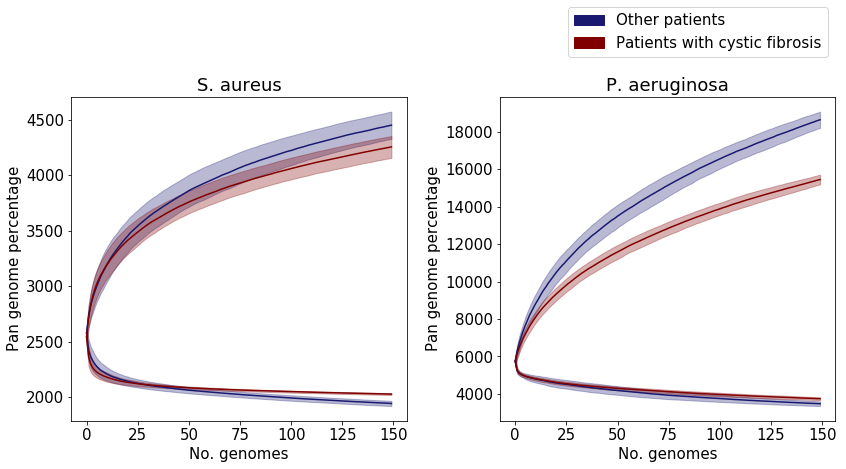

In [28]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
keyword2col = {'nonCF':'midnightblue', 'full':'lightslategrey', 'CF':'maroon'}
keyword2col = {'nonCF':'midnightblue', 'CF':'maroon'}
fig, axes = plt.subplots(1,2, sharey = False, figsize = (12, 7))

no = 150

pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/pangenome_res_nonCF.csv')
max_SA = pangenome_res.iloc[no]['Pan genome (mean)']


pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pangenome_res_nonCF.csv')
max_PA = pangenome_res.iloc[no]['Pan genome (mean)']

rows = {}
i = 0
for spe, title in {'pseudomonas':'P. aeruginosa', 'staphylococcus':'S. aureus'}.items():
    ax = axes[i]
    for keyword, color in keyword2col.items():
        
        pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pangenome_res_%s.csv'%(spe, keyword))
        pan, core = pangenome_res.iloc[no]['Pan genome (mean)'], pangenome_res.iloc[no]['Core genome (mean)']
        rows['%s - %s'%(spe, keyword)] = {'core genome size':core, 'pan genome size':pan}
        m = max_SA if spe == 'staphylococcus' else max_PA
        plot_curves(pangenome_res.iloc[:no], ax, color)
        plot_curves(100*pangenome_res.iloc[:no]/m, ax, color)
    ax.set_ylim(10, 110)
    ax.set_ylabel('Pan genome percentage')
    ax.set_xlabel('No. genomes')
    ax.set_title(title)
    i+= 1


plt.legend(handles = [mpatches.Patch(color='midnightblue', label='Other patients'),
#            mpatches.Patch(color='lightslategrey', label='All strains'),
            mpatches.Patch(color='maroon', label='Patients with cystic fibrosis')
           ], bbox_to_anchor = [1,1.3])
plt.tight_layout()

# plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/pangenome_curves.svg')
# plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/pangenome_curves.png')

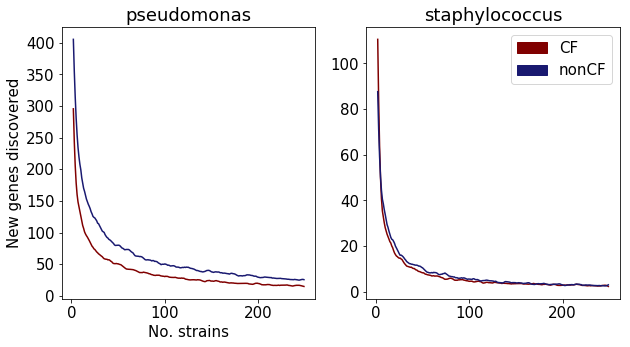

In [220]:
fig, axes = plt.subplots(1,2, figsize = (10, 5))
keyword2col = {'nonCF':'midnightblue', 'CF':'maroon'}
i = 0
rows = {}
for spe in ['pseudomonas', 'staphylococcus']:
    for keyword, color in keyword2col.items():
        pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pangenome_res_%s.csv'%(spe, keyword))
    
        rows['%s - %s'%(spe, keyword)] = {x:str(round(y, 2)) for x,y in get_all_fitting_params(pangenome_res).items()}  
        
        new_genes = np.array(pangenome_res['New genes (mean)'].iloc[2:250], dtype = float)        
        x = pangenome_res.index.tolist()[2:250]

        ysmooth = scipy.signal.savgol_filter(new_genes, 11, 3)
        axes[i].plot(x, ysmooth, color = color, label = keyword)
    axes[i].set_title(spe)
    i += 1
    
axes[i-1].legend(handles =[mpatches.Patch(color = col, label = lab) for lab, col in keyword2col.items()])
axes[0].set_ylabel('New genes discovered')
axes[0].set_xlabel('No. strains')

plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/newgenes_curves.svg')
plt.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/newgenes_curves.png')

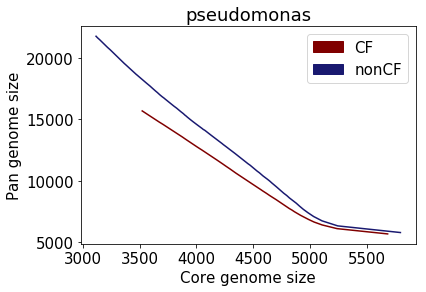

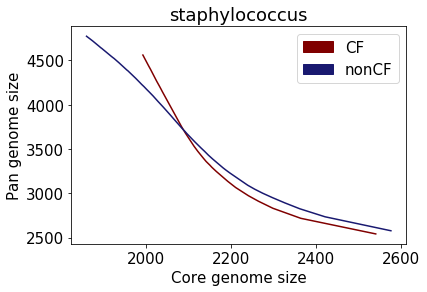

In [120]:
for spe in ['pseudomonas', 'staphylococcus']:
    plt.figure()
    for keyword, color in keyword2col.items():
        pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pangenome_res_%s.csv'%(spe, keyword))
        
        plt.plot(pangenome_res['Core genome (mean)'].iloc[:250], pangenome_res['Pan genome (mean)'].iloc[:250], color = color)
        plt.xlabel('Core genome size')
        plt.ylabel('Pan genome size')
        plt.title(spe)

    plt.legend(handles =[mpatches.Patch(color = c, label = l) for l,c in keyword2col.items()])
#     plt.title('Pangenome space')

In [77]:
pd.DataFrame(rows)

,pseudomonas - CF,pseudomonas - nonCF,staphylococcus - CF,staphylococcus - nonCF
core genome size,3521.002,3115.105,1991.911,1858.827
pan genome size,15691.620,21771.118,4563.956,4776.003


In [221]:
keyword2col = {'nonCF':'midnightblue', 'full':'lightslategrey', 'CF':'maroon'}
for spe in ['pseudomonas', 'staphylococcus']:
    for keyword, color in keyword2col.items():
        pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pangenome_res_%s.csv'%(spe, keyword))
        rows['%s - %s'%(spe, keyword)] = {x:str(round(y, 2)) for x,y in get_all_fitting_params(pangenome_res).items()}  
    
pd.DataFrame(rows)

,pseudomonas - CF,pseudomonas - full,pseudomonas - nonCF,staphylococcus - CF,staphylococcus - full,staphylococcus - nonCF
C (pan),3527.93,2691.55,3264.69,1761.44,1701.39,1666.57
K (new genes),0.0,0.0,0.0,0.0,0.0,0.0
K (pan),7974766845.76,6506905081.75,669083817.87,19853895283122.56,6046214643136.4,48929613169614.54
alpha (new genes),0.49,0.47,0.44,0.65,0.59,0.55
alpha (pan),0.67,0.65,0.62,0.78,0.77,0.78
k1 (core),1834.46,-170953.02,2001.05,205.26,654.42,471.31
k2 (core),1107.95,-170137.47,1718.12,527.79,485.29,598.01
phi (core),2995.06,345497.59,2977.49,1974.38,1467.84,1548.28
tau1 (core),190.99,-100168.18,102.82,94.73,575.56,5.06
tau2 (core),2.72,-100012.67,1.29,2.26,4.89,376.24


# pan allelome (try1)

In [5]:
spe = 'pseudomonas'
directory = '/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix/'%spe
allele_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()

directory = '/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix_na/'%spe
allele_matrix_na = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()
col_rows = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/col_rows.p', 'rb'))
gid_order = col_rows[0]
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/FT_LRI_f.csv'%spe, dtype = {'Genome ID':str}).set_index('Genome ID').loc[gid_order].reset_index()
d = {'full': SoI_FT.index.tolist(), 'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1].index.tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0].index.tolist()}
    
output_na= '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pan_allelome_na.csv'
output_aa= '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pan_allelome_aa.csv'
pan_variants_CF = get_pan_variants_curve( allele_matrix_na[:,d['CF']], allele_matrix[:,d['CF']], 200, output_na = output_na, output_aa = output_aa)


output_na= '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pan_allelome_na_nonCF.csv'
output_aa= '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pan_allelome_aa_nonCF.csv'
pan_variants_nonCF = get_pan_variants_curve(allele_matrix_na[:,d['nonCF']], allele_matrix[:,d['nonCF']], 200 , output_na = output_na, output_aa = output_aa)


In [5]:
spe = 'staphylococcus'
directory = '/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix/'%spe
allele_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()

directory = '/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix_na/'%spe
allele_matrix_na = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()
col_rows = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix/col_rows.p'%spe, 'rb'))
gid_order = col_rows[0]
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str}).set_index('Genome ID').loc[gid_order].reset_index()
d = {'full': SoI_FT.index.tolist(), 'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1].index.tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0].index.tolist()}

In [6]:
output_na= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_na.csv'%spe
output_aa= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_aa.csv'%spe
pan_variants_CF = get_pan_variants_curve( allele_matrix_na[:,d['CF']], allele_matrix[:,d['CF']], 200, output_na = output_na, output_aa = output_aa)


output_na= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_na_nonCF.csv'%spe
output_aa= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_aa_nonCF.csv'%spe
pan_variants_nonCF = get_pan_variants_curve(allele_matrix_na[:,d['nonCF']], allele_matrix[:,d['nonCF']], 200 , output_na = output_na, output_aa = output_aa)

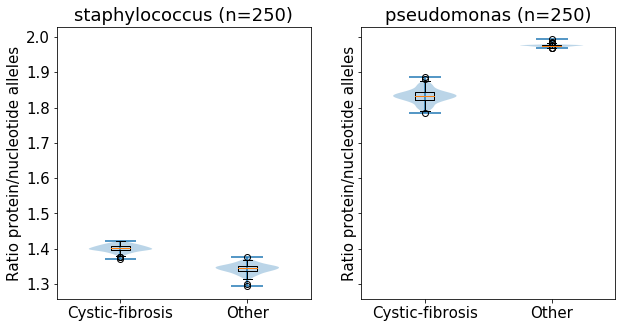

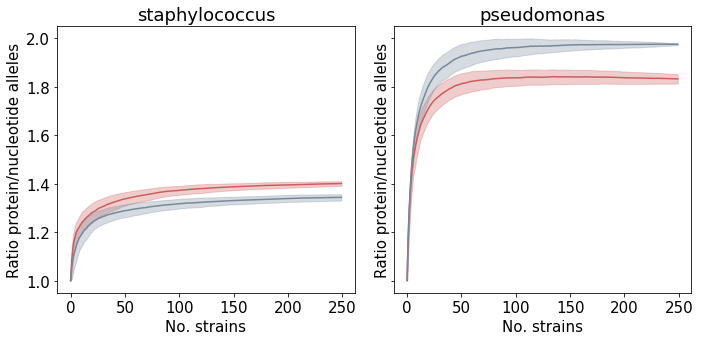

In [98]:
fig, axes = plt.subplots(1,2, figsize = (10, 5), sharey = True)
i= 0

fig2, axes2 = plt.subplots(1,2, figsize = (10, 5), sharey = True )
for spe in ['staphylococcus', 'pseudomonas']:
    ax = axes[i]
    output_na= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_na.csv'%spe
    output_aa= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_aa.csv'%spe    
    pan_variants_CF = pd.read_csv(output_na, index_col = ['Unnamed: 0'])/pd.read_csv(output_aa, index_col = ['Unnamed: 0'])
    output_na= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_na_nonCF.csv'%spe
    output_aa= '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pan_allelome_aa_nonCF.csv'%spe    
    pan_variants_nonCF = pd.read_csv(output_na, index_col = ['Unnamed: 0'])/pd.read_csv(output_aa, index_col = ['Unnamed: 0'])    
    
    matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
    ax.boxplot([pan_variants_CF.iloc[250], pan_variants_nonCF.loc[250]])
    ax.violinplot([pan_variants_CF.iloc[250], pan_variants_nonCF.loc[250]])
    ax.set_xticks([1,2])
    ax.set_xticklabels(['Cystic-fibrosis', 'Other'])
    ax.set_ylabel('Ratio protein/nucleotide alleles')
    ax.set_title('%s (n=250)'%spe)
    
    
    ax2 = axes2[i]
    yavg =  pan_variants_CF.iloc[:250].mean(axis = 1)
    yplus =  pan_variants_CF.iloc[:250].mean(axis = 1) + pan_variants_CF.iloc[:250].std(axis = 1)
    yminus =  pan_variants_CF.iloc[:250].mean(axis = 1) - pan_variants_CF.iloc[:250].std(axis = 1)
    xrange = pan_variants_CF.iloc[:250].index
    ax2.fill_between(xrange, yminus, yplus, color = 'indianred', alpha = 0.3)
    ax2.plot(xrange, yavg, color = 'indianred')    

    yavg =  pan_variants_nonCF.iloc[:250].mean(axis = 1)
    yplus =  pan_variants_nonCF.iloc[:250].mean(axis = 1) + pan_variants_nonCF.iloc[:250].std(axis = 1)
    yminus =  pan_variants_nonCF.iloc[:250].mean(axis = 1) - pan_variants_nonCF.iloc[:250].std(axis = 1)
    xrange = pan_variants_nonCF.iloc[:250].index
    ax2.fill_between(xrange, yminus, yplus, color = 'lightslategrey', alpha = 0.3)
    ax2.plot(xrange, yavg, color = 'lightslategrey')    
    ax2.set_title(spe)
    ax2.set_ylabel('Ratio protein/nucleotide alleles')
    ax2.set_xlabel('No. strains')
    i +=1
plt.tight_layout()
fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/nucleotide_to_protein_variants.svg')

In [4]:
directory = '/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix_na/'%spe
allele_matrix_na = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()

(587547, 712)

In [9]:
spe = 'staphylococcus'
directory = '/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix/'%spe
allele_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()

SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str})
d = {'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1].index.tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0].index.tolist()}

bootstrap_no = 1000

for keyword, subset in d.items():
    
    input_table = allele_matrix[:,subset]
    output_file = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/allelome_sample_%s.csv'%keyword
    pangenome_res = get_pangenome_multi(input_table, bootstrap_no, output_file = output_file)
    pangenome_res.to_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/pangenome/allelome_res_%s.csv'%keyword)

In [90]:
spe = 'pseudomonas'
directory = '/home/yara/Documents/cystic_fibrosis/data/%s/allele_matrix/'%spe
allele_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()

col_rows = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/col_rows.p', 'rb'))
gid_order = col_rows[0]
SoI_FT = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/FT_LRI_f.csv'%spe, dtype = {'Genome ID':str}).set_index('Genome ID').loc[gid_order].reset_index()

d = {'CF':SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 1].index.tolist(), 'nonCF': SoI_FT.loc[SoI_FT['cystic_fibrosis_status'] == 0].index.tolist()}

bootstrap_no = 1000

for keyword, subset in d.items():
    
    input_table = allele_matrix[:,subset]
    output_file = '/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/allelome_sample_%s.csv'%(spe, keyword)
    pangenome_res = get_pangenome_multi(input_table, bootstrap_no, output_file = output_file)
    pangenome_res.to_csv('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/allelome_res_%s.csv'%(spe, keyword))

MemoryError: 

In [263]:
PA_seq_lengths = []
for fa in glob('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/prokka/*/*.faa'):
    with open(fa, 'r') as f:
        string = f.read()
    PA_seq_lengths += [len(''.join(x.split('\n')[1:])) for x in string.split('\n>')]
    
SA_seq_lengths = []
for fa in glob('/home/yara/Documents/UO1/Data/Sequences/prokka/*/*.faa'):
    with open(fa, 'r') as f:
        string = f.read()
    SA_seq_lengths += [len(''.join(x.split('\n')[1:])) for x in string.split('\n>')]

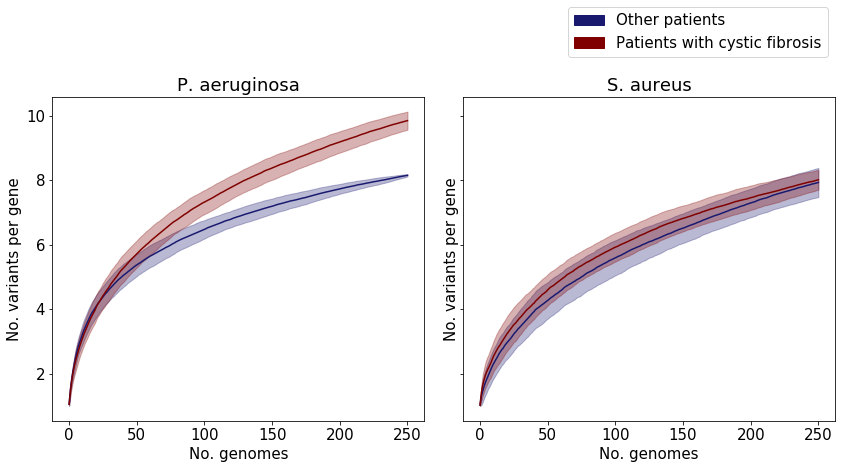

In [92]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
keyword2col = {'nonCF':'midnightblue', 'full':'lightslategrey', 'CF':'maroon'}
keyword2col = {'nonCF':'midnightblue', 'CF':'maroon'}
fig, axes = plt.subplots(1,2, sharey = True, figsize = (12, 7))

i = 0

# pa = np.mean(PA_seq_lengths)
# sa = np.mean(SA_seq_lengths)

pa = 322.27295462701704
sa = 298.61240177183186

rows= {}
for spe, title in {'pseudomonas':'P. aeruginosa', 'staphylococcus':'S. aureus'}.items():
    ax = axes[i]
    for keyword, color in keyword2col.items():
        
        allelome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/allelome_res_%s.csv'%(spe, keyword)).iloc[:251]
        pangenome_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/%s/pangenome/pangenome_res_%s.csv'%(spe, keyword)).iloc[:251]
        n = pa if spe == 'pseudomonas' else sa
        to_plot = allelome_res/pangenome_res
        
        rows['%s - %s'%(spe, keyword)] = {x:str(round(y, 2)) for x,y in get_all_fitting_params(to_plot.iloc[:250]).items()}  
        rows['%s - %s'%(spe, keyword)].update({'No. variants per protein family': to_plot.iloc[250]['Pan genome (mean)']})

        yavg = to_plot['Pan genome (mean)']
        yminus = to_plot['Pan genome (mean)'] - allelome_res['Pan genome (std)']/pangenome_res['Pan genome (mean)']
        yplus = to_plot['Pan genome (mean)'] + allelome_res['Pan genome (std)']/pangenome_res['Pan genome (mean)']
        xrange = to_plot.index
        ax.fill_between(xrange, yminus, yplus, color = color, alpha = 0.3)
        ax.plot(xrange, yavg, color = color)    

#         ax.plot(to_plot.iloc[:250].index, to_plot['Pan genome (mean)'].iloc[:250], color = color)
#         plot_curves(to_plot.iloc[:250], ax, color)
        
    ax.set_ylabel('No. variants per gene')
    ax.set_xlabel('No. genomes')
    ax.set_title(title)
    i+= 1


plt.legend(handles = [mpatches.Patch(color='midnightblue', label='Other patients'),
#            mpatches.Patch(color='lightslategrey', label='All strains'),
            mpatches.Patch(color='maroon', label='Patients with cystic fibrosis')
           ], bbox_to_anchor = [1,1.3])
plt.tight_layout()

fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/variants_per_gene.svg')

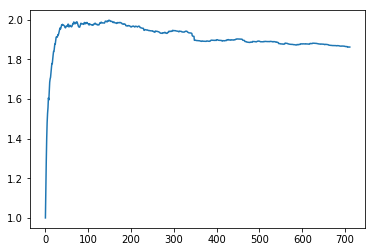

In [44]:
plt.plot(pangenome_na.index, pangenome_na['pan']/pangenome_pa['pan'])

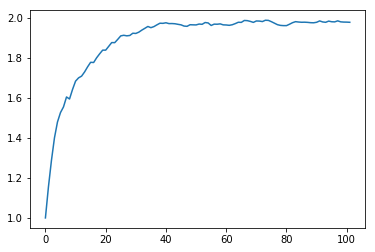

In [41]:
plt.plot(pangenome_na.index, pangenome_na['pan']/pangenome_pa['pan'])

In [378]:
pd.DataFrame(rows)

,pseudomonas - CF,pseudomonas - nonCF,staphylococcus - CF,staphylococcus - nonCF
C (pan),-1.23,-3.73,-0.43,0.1
K (new genes),2347.45,1416.56,2331832.08,74.88
K (pan),13.43,10493.78,2.57,0.69
No. variants per protein family,9.85517,8.06543,8.01839,7.93572
alpha (new genes),-0.23,-0.21,-0.16,-0.35
alpha (pan),0.7,0.83,0.67,0.6
k1 (core),0.34,1.77,1.57,0.98
k2 (core),1.93,-0.33,0.3,0.38
phi (core),0.02,0.05,0.03,0.03
tau1 (core),15.31,2.09,1.21,2.13


# foreign accessory genome

In [ ]:
# https://journals.plos.org/plosgenetics/article/file?id=10.1371/journal.pgen.1008114&type=printable

# phylogenetic tree

In [7]:
# P. aeruginosa

cdhit_clusters = get_cdhit_clusters('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pseudomonas_pangenome_cdhit.clstr')
cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}
cdhit_in_genomes = defaultdict(dict)
for gene_id, cluster_id in cdhit_clusters_rev.items():
    if gene_id != '':
        cdhit_in_genomes[gene_id.split('_')[0]].update({cluster_id: gene_id})
cdhit_in_genomes = pd.DataFrame(cdhit_in_genomes).fillna(0)

cdhit_in_genomes_b = cdhit_in_genomes.copy()
cdhit_in_genomes_b[cdhit_in_genomes_b != 0] = 1

organism = 'Pseudomonas (gene families)'
output_file = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pangenome_sample.csv'
pangenome_res_pseudomonas = get_pangenome_counts(cdhit_in_genomes, bootstrap_no, output_file = output_file)
pangenome_res.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pangenome_res.csv')
heaps_estimate1 = return_heaps_estimates(pangenome_res_pseudomonas[0]).rename(index = {1:organism})

KeyError: 0

In [49]:
not_duplicated = [cdhit for cdhit, genes in cdhit_clusters.items() if max(Counter([gene.split('_')[0] for gene in genes]).values()) == 1]
conserved_families = [x for x,y in cdhit_in_genomes_b.sum(axis = 1).to_dict().items() if y == cdhit_in_genomes_b.shape[1] if x in not_duplicated]
directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/'
core_cdhit = cdhit_in_genomes.loc[conserved_families]

In [59]:
all_alleles = {}
alleles_in_gids = defaultdict(dict)
locus2allele = {}
count = 0
all_sequences = []
iii = 0


for gid in core_cdhit.columns:
    ffn_file = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/prokka/%s/%s.ffn'%(gid, gid)
    with open(ffn_file, 'r') as f:
        string = f.read()
    gid_sequences = {''.join(x.split('\n')[1:]):x.split('\n')[0].replace('>','').split(' ')[0] for x in string.split('\n>') if x.split('\n')[0].replace('>','').split(' ')[0] in core_cdhit[gid].tolist()} 
    new_sequences = set(gid_sequences.keys())-set(all_sequences)
    
    all_alleles.update(zip(new_sequences, ['Allele_%s'%str(i+count) for i in range(len(new_sequences))]))
    locus2allele.update({gene_id:all_alleles[seq] for seq,gene_id in gid_sequences.items() if seq in new_sequences})
    
    gid_alleles = [all_alleles[seq] for seq in gid_sequences.keys()]
    alleles_in_gids[gid] ={ID:1 for ID in gid_alleles}
    count += len(new_sequences)
    all_sequences = set(list(gid_sequences.keys())+list(all_sequences))
    
allele_matrix = pd.DataFrame(alleles_in_gids)        
allele_matrix = allele_matrix.fillna(0)

sparse_allele_matrix = scipy.sparse.csc_matrix(np.array(allele_matrix))
scipy.sparse.save_npz('%s/phylogenomics/allele_matrix.npz'%directory, sparse_allele_matrix)
col_rows = [allele_matrix.columns, allele_matrix.index]
pickle.dump(col_rows, open('%s/phylogenomics/col_rows.p'%directory, 'wb'))
pickle.dump(all_alleles, open('%s/phylogenomics/all_alleles_seqs.p'%directory, 'wb'))
pickle.dump(locus2allele, open('%s/phylogenomics/locus2allele.p'%directory, 'wb'))

In [78]:
from scipy.spatial.distance import pdist,squareform

allelic_distances = pdist(allele_matrix.T, 'hamming')
allelic_distances_squareform = squareform(allelic_distances)
allelic_distances_df = pd.DataFrame(allelic_distances_squareform)

In [94]:
# https://biopython.org/wiki/Phylo
from Bio.Phylo.Consensus import *
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor, DistanceMatrix
import Bio.Phylo

In [129]:
ddm = [allelic_distances_squareform[i][:i+1].tolist() for i in range(len(allelic_distances_squareform))]
dm = DistanceMatrix(names = allele_matrix.columns.tolist(), matrix = ddm)
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)
Bio.Phylo.write(tree, '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/phylogenomics/tree.nhx','newick')

In [150]:
tseeman_MLST = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/phylogenomics/tseeman_mlst.csv', sep = '\t', names = ['fna_file', 'species', 'MLST', 'acsA', 'aroE', 'guaA', 'mutL', 'nuoD', 'ppsA', 'trpE'])
tseeman_MLST['Genome ID'] = [x.split('/')[-1].replace('.fna','') for x in tseeman_MLST['fna_file']]
tseeman_MLST['MLST_i'] = ['ST_%s'%i for i in tseeman_MLST['MLST']]
tseeman_MLST.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/phylogenomics/tseeman_mlst_m.csv')

In [192]:
FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f.csv', dtype = {'Genome ID':str})
FT_LRI['cystic_fibrosis_status_i'] = ['cystic fibrosis' if x == 1 else 'other' for x in FT_LRI['cystic_fibrosis_status'] ]
FT_LRI = FT_LRI.fillna('')
large_studies = [x for x,y in Counter(FT_LRI['Additional Metadata']).items() if y > 30 if x != '']
large_studies = {s:'Study_%d'%i for i, s in enumerate(large_studies)}
FT_LRI['Study'] = [large_studies[x] if x in large_studies.keys() else 'miscellaneous' for x in FT_LRI['Additional Metadata']]
FT_LRI.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f2.csv')

In [171]:
with open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/phylogenomics/tree.nhx','r') as f:
    string = f.read()
    
set(re.findall('(?<=\()[0-9].+?[0-9](?=\:)', string)) - set(allele_matrix.columns)

set()

In [156]:
[x for x,y in Counter(tseeman_MLST['MLST_i']).items() if y > 20]

['ST_27', 'ST_274', 'ST_179', 'ST_17', 'ST_-']

In [8]:
directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/'
selected_features_final = pd.read_csv('%s/functional_annotation/selected_features_final_m.csv'%directory, index_col = ['Unnamed: 0']).fillna('')
cdhit2count = dict(cdhit_in_genomes.sum(axis = 1))
allele2cdhit = pickle.load(open('%s/allele_matrix/allele2cdhit.p'%directory, 'rb'))

Text(0, 0.5, 'Conservation of selected genes')

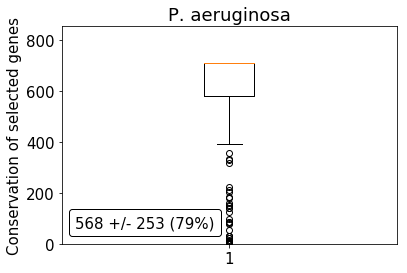

In [29]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, ax = plt.subplots(1,1)
dist = [cdhit2count[allele2cdhit[x]] for x in selected_features_final['Allele ID']]
mean, std, perc = np.mean(dist), np.std(dist), np.mean(dist)/cdhit_in_genomes.shape[1]
ax.boxplot(dist)
ax.set_ylim(0, 1.2*cdhit_in_genomes.shape[1])
equation = '%d +/- %d (%d%%)'%(int(mean),int(std), int(100*perc ))
at = AnchoredText(equation, prop=dict(size=15), frameon=True, loc=3)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
ax.set_title('P. aeruginosa')
ax.set_ylabel('Conservation of selected genes')

In [90]:
heaps_estimate

,K estimate,Gamma standard deviation,Gamma estimate,K standard deviation
Staphylococcus (gene families),397.248,0.001,0.314,1.435
Pseudomonas (gene families),1314.442,0.001,0.422,10.570


Text(0.5, 0, 'No. strains')

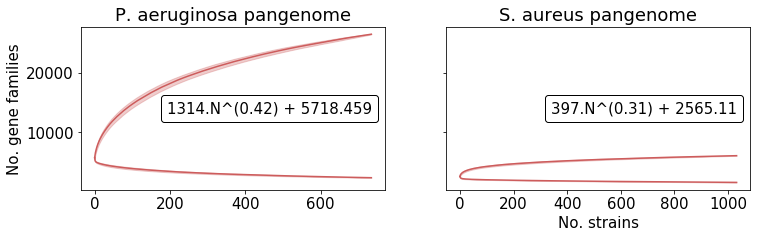

In [109]:
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, axes = plt.subplots(1,2, sharey = True, figsize = (12, 3))

i = 0
for word in ['Pan', 'Core']:
    
    yavg = pangenome_res_pseudomonas[0]['%s genome (mean)'%word]
    yminus = pangenome_res_pseudomonas[0]['%s genome (mean)'%word] - pangenome_res_pseudomonas[0]['%s genome (std)'%word]
    yplus = pangenome_res_pseudomonas[0]['%s genome (mean)'%word] + pangenome_res_pseudomonas[0]['%s genome (std)'%word]
    x = range(len(pangenome_res_pseudomonas[0]))
    axes[i].fill_between(x, yminus, yplus, color = 'indianred', alpha = 0.3)
    axes[i].plot(x, yavg, color = 'indianred')
axes[i].set_title('P. aeruginosa pangenome')   
axes[i].set_ylabel('No. gene families')

mean  = pangenome_res_pseudomonas[0]['Pan genome (mean)'].iloc[0]
organism = 'Pseudomonas (gene families)'
gamma, K = str(round(heaps_estimate.loc[organism,'Gamma estimate'], 2)), str(int(round(heaps_estimate.loc[organism,'K estimate'], 0)))
equation = '%s.N^(%s) + %s'%(K, gamma, mean)
at = AnchoredText(equation, prop=dict(size=15), frameon=True, loc=5)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[i].add_artist(at)

i = 1
for word in ['Pan', 'Core']:
    
    yavg = pangenome_res['%s genome (mean)'%word]
    yminus = pangenome_res['%s genome (mean)'%word] - pangenome_res['%s genome (std)'%word]
    yplus = pangenome_res['%s genome (mean)'%word] + pangenome_res['%s genome (std)'%word]
    x = range(len(pangenome_res))
    axes[i].fill_between(x, yminus, yplus, color = 'indianred', alpha = 0.3)
    axes[i].plot(x, yavg, color = 'indianred')
axes[i].set_title('S. aureus pangenome')   

mean  = pangenome_res['Pan genome (mean)'].iloc[0]
organism = 'Staphylococcus (gene families)'
gamma, K = str(round(heaps_estimate.loc[organism,'Gamma estimate'], 2)), str(int(round(heaps_estimate.loc[organism,'K estimate'], 0)))
equation = '%s.N^(%s) + %s'%(K, gamma, mean)
at = AnchoredText(equation, prop=dict(size=15), frameon=True, loc=5)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[i].add_artist(at)

plt.xlabel('No. strains')

fig.savefig('/home/yara/Documents/cystic_fibrosis/output/pangenomes.svg')

In [ ]:
fig.savefig('/home/yara/Documents/cystic_fibrosis/output/Figures/pangenomes.svg')

In [ ]:
# directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/'
# allele_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense()
# bootstrap_no = 3
# panallelome_res_pseudomonas = get_pangenome_counts(allele_matrix, bootstrap_no)

In [ ]:
panallelome_res_pseudomonas